In [18]:
import numpy as np
import json
from datasets import load_dataset
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import torch
import albumentations
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
import requests
from transformers import pipeline

In [3]:
# start label studio to create bounding boxes

#!label-studio start

In [2]:
# read coco annotations
with open('result.json') as f:
    cocodata = json.load(f)

In [14]:
# store annotations in dictionary

# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
    # Remove the image directory from the file name
    image['file_name'] = image['file_name'].split('/')[-1]
    image['image_id'] = image['id']
    # Extend the image dict with bounding boxes and class labels
    image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    # Iterate through the annotations (bounding boxes and labels)
    for annot in cocodata['annotations']:
        # Check if the annotation matches the image
        if annot['image_id'] == image['id']:
            # Add the annotation
            image['objects']['bbox'].append(annot['bbox'])
            image['objects']['category'].append(annot['category_id'])
            image['objects']['area'].append(annot['area'])
            image['objects']['id'].append(annot['id'])
    # Append the image dict with annotations to the list
    huggingdata.append(image)


In [15]:
# save the dictionary to a file

with open("metadata.jsonl", 'w') as f:
    for item in huggingdata:
        f.write(json.dumps(item) + "\n")


In [3]:
# read in dataset (assuming that the correct directory organization has been created)

candy_data = load_dataset('imagefolder', data_dir='data', split='train')

In [21]:
candy_data.features['objects']['category']

AttributeError: 'Sequence' object has no attribute 'names'

In [4]:
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}
id2label

{0: 'Black_star',
 1: 'Cat',
 2: 'Grey_star',
 3: 'Insect',
 4: 'Moon',
 5: 'Owl',
 6: 'Unicorn_head',
 7: 'Unicorn_whole'}

In [12]:
# install datasets to start tutorial 

!pip install -q datasets transformers evaluate timm albumentations

  You can safely remove it manually.


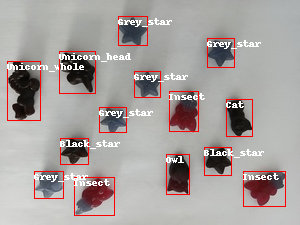

In [5]:
# visualize image

image = candy_data[0]["image"]
annotations = candy_data[0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")
    
image

In [6]:
# pre-process data

# set checkpoint
checkpoint = "facebook/detr-resnet-50"

# instantiate image processor
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [7]:
# augment images

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params = albumentations.BboxParams(format="coco", label_fields=["category"])
)

In [8]:
# format annotations for a sinlge image
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [9]:
# batch function for image transformation and annotation formatting
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [10]:
# apply transformations to dataset
candy_data = candy_data.with_transform(transform_aug_ann)

In [11]:
# verify transformations worked
candy_data[0]

{'pixel_values': tensor([[[0.9817, 0.9817, 0.9817,  ..., 1.1358, 1.1358, 1.1358],
          [0.9817, 0.9817, 0.9817,  ..., 1.1358, 1.1358, 1.1358],
          [0.9817, 0.9817, 0.9817,  ..., 1.1529, 1.1529, 1.1529],
          ...,
          [1.3070, 1.3070, 1.3070,  ..., 1.7352, 1.7180, 1.7180],
          [1.3070, 1.3070, 1.3070,  ..., 1.7180, 1.7180, 1.7180],
          [1.3070, 1.3070, 1.3070,  ..., 1.7180, 1.7180, 1.7180]],
 
         [[1.1155, 1.1155, 1.1155,  ..., 1.3431, 1.3431, 1.3431],
          [1.1155, 1.1155, 1.1155,  ..., 1.3606, 1.3431, 1.3431],
          [1.1155, 1.1155, 1.1155,  ..., 1.3782, 1.3606, 1.3431],
          ...,
          [1.4657, 1.4657, 1.4657,  ..., 1.9384, 1.9384, 1.9384],
          [1.4657, 1.4657, 1.4657,  ..., 1.9384, 1.9384, 1.9384],
          [1.4657, 1.4657, 1.4657,  ..., 1.9384, 1.9384, 1.9384]],
 
         [[1.2457, 1.2457, 1.2457,  ..., 1.5245, 1.5245, 1.5245],
          [1.2457, 1.2457, 1.2457,  ..., 1.5245, 1.5245, 1.5245],
          [1.2457, 1.245

In [12]:
# function to batch images together, pad images to ensure same dimensions, pixel mask to know what pixels are real vs padding
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

candy_data.with_transform(collate_fn)

Dataset({
    features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
    num_rows: 10
})

In [13]:
# training begins

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [14]:
# set hyperparams

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    # set fp16 to false unless using cuda (nvidia gpu)
    fp16=False,
    save_steps=200,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    # not sure if we need to push to hugging face
    push_to_hub=False,
)

In [15]:
# call training method

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data,
    tokenizer=image_processor,
)

trainer.train()

 50%|█████     | 10/20 [02:22<02:07, 12.73s/it]

{'loss': 3.0623, 'learning_rate': 5e-06, 'epoch': 5.0}


100%|██████████| 20/20 [04:47<00:00, 14.37s/it]

{'loss': 2.5377, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 287.4041, 'train_samples_per_second': 0.348, 'train_steps_per_second': 0.07, 'train_loss': 2.800020694732666, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=2.800020694732666, metrics={'train_runtime': 287.4041, 'train_samples_per_second': 0.348, 'train_steps_per_second': 0.07, 'train_loss': 2.800020694732666, 'epoch': 10.0})

In [16]:
# save the model
trainer.save_model('candy_detector')

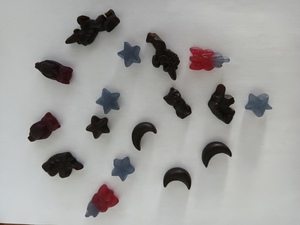

In [23]:
# run finetuned model on a test image and print results

image = Image.open("cd_35.jpg")

obj_detector = pipeline("object-detection", model="candy_detector")
obj_detector(image, threshold=0.01)

draw = ImageDraw.Draw(image)

# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     x, y, x2, y2 = tuple(box)
#     draw.rectangle((x, y, x2, y2), outline="red", width=1)
#     draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

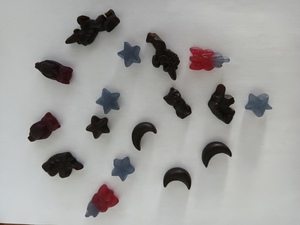

In [24]:
image_processor = AutoImageProcessor.from_pretrained("candy_detector")
model = AutoModelForObjectDetection.from_pretrained("candy_detector")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    
    
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image